In [79]:
import numpy as np
from scipy import interpolate
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

In [80]:
#Constants for Pinsky Rinzel
Gna = 30
Gkdr = 15
Gkca = 15
Gkahp = 0.8
Gca = 10
Gl = 0.1
Gc = 2.1
Vna = 60
Vk = -75
Vca = 80
Vl = -60
p = 0.5
Ca = 0.21664282 
Cm = 3
Gnmda = 0#1.25
Vnmda = 0
Gmax = 0.675
Vsyn = 0

Isapp = 0.75
Idapp = 0.0

In [81]:
#Constants for AMPAR
C0_C1 = 4.59E6
C1_C0 = 4.26e3
C1_C2 = 2.84E7
C2_C1 = 3.26E3
C2_O  = 4.24E3
O_C2  = 9.00E2
C1_C3 = 2.89E3
C3_C1 = 3.92E1
C2_C4 = 1.72E2
C4_C2 = 0.727
O_C5  = 1.77E1
C5_O  = 4.00
C3_C4 = 1.27E6
C4_C3 = 4.57E1
C4_C5 = 1.68E1
C5_C4 = 1.90E2
n_vesicle = 1
n_Glu = n_vesicle * 3000
N_AMPAR =  20
#Isingle_max = 6 #Gmax * (Vd - E)

In [82]:
#Alpha and Beta functions and Chi
#AMPAR Function definition

def H(X):
    if X < 0:
        return 0
    else: 
        return 1

def alphaM(Vs):
    return (0.32*(-46.9 - Vs)/(np.exp((-46.9 - Vs)/4) - 1))

def betaM(Vs):
    return (0.28*(Vs + 19.9)/(np.exp((Vs + 19.9)/5) - 1))

def alphaN(Vs):
    return ((0.016*(-24.9 - Vs))/(np.exp((-24.9 - Vs)/5) - 1))

def betaN(Vs):
    return (0.25*np.exp(-1 - 0.025*Vs))

def alphaH(Vs):
    return (0.128*np.exp((-43-Vs)/18))

def betaH(Vs):
    return (4/(1 + np.exp((-20-Vs)/5)))

def alphaS(Vd):
    return (1.6/(1 + np.exp(-0.072*(Vd - 5))))

def betaS(Vd):
    return (0.02*(Vd + 8.9)/(np.exp((Vd + 8.9)/5) - 1))

#def alphaC(Vd):
    #return ((1 - H(Vd + 10)*np.exp((Vd + 50)/11 - (Vd + 53.5)/27)/18.975) + H(Vd + 10)*(2*np.exp((-53.5-Vd)/27)))

#def betaC(Vd):
    #return ((1 - H(Vd + 10))*(2*np.exp((-53.5 - Vd)/27) - alphaC(Vd)))

#def alphaQ(Ca):
    #return (min(0.00002*Ca,0.01))

#def betaQ(Ca):
    #return (0.001)

#def chi(Ca):
   # return (min(Ca/250,1))
    
def qinf(Ca):
    return ((0.7894 * np.exp(0.0002726*Ca)) - (0.7292 * np.exp(-0.01672*Ca)))

def tauq(Ca):
    return (657.9 * np.exp(-0.02023*Ca)) + (301.8 * np.exp(-0.002381*Ca))

def cinf(Vd):
    return ((1.0/(1.0 + np.exp((-10.1 - Vd)/0.1016)))**0.00925)

def tauc(Vd):
    return (3.627 * np.exp(0.03704*Vd))

def chi(Ca):
    return (1.073*np.sin(0.003453*Ca+0.08095) \
            + 0.08408*np.sin(0.01634*Ca-2.34)\
            + 0.01811*np.sin(0.0348*Ca-0.9918))

def GluA(T):
    A = 1
    tau = 1
    Glu = np.zeros(len(T))
    tspike = [1,5]
    for ts in tspike:
        #print Glu
        Glu += [A*np.exp(-(t-ts)/tau) if t>=ts else 0 for t in T]
    #print Glu
    
    Glu = interpolate.interp1d(T, Glu)
    return Glu

def Isingle_max(Vd):
    return Gmax * (Vd - Vsyn)

In [83]:
tmin, tmax, dt = 0, 1000, 0.1
T = np.arange(tmin,tmax,dt)

Glu = GluA(T)
def dVdt(V, t):
    C0, C1, C2, C3, C4, C5, O, Vs, Vd, m, n, h, s, c, q, Ca  = V
    
    Iampa = N_AMPAR * O * (Isingle_max(Vd))
    try:
        #Equations for currents
        Ina = Gna * m**2 * h * (Vs - Vna) #Mi is minfinity
        Ikdr = Gkdr * n * (Vs - Vk)
        Ica = Gca * s**2 * (Vd - Vca)
        Ikca = Gkca * c * chi(Ca) * (Vd - Vk)
        Ikahp = Gkahp * q * (Vd - Vk)
        Isd = Gc * (Vs - Vd)
        Ids = -Isd
        Ileakd = Gl * (Vd - Vl)
        Ileaks = Gl * (Vs - Vl)
        Inmda = Gnmda*(Vd - Vnmda)/(1 + 0.28*np.exp(-0.062*(Vd - Vnmda)))
        
        #Equation for AMPA current
        #Glu = GluA(T)
        dC0 = - C0_C1*C0*Glu(t) + C1_C0*C1
        dC1 = - C1_C3*C1 + C3_C1*C3 - C1_C2*C1*Glu(t) + C2_C1*C2 + C0_C1*C0*Glu(t) - C1_C0*C1
        dC2 = - C2_O*C2 + O_C2*O - C2_C4*C2 + C4_C2*C4 + C1_C2*C1*Glu(t) - C2_C1*C2
        dC3 = - C3_C4*C3*Glu(t) + C4_C3*C4 + C1_C3*C1 - C3_C1*C3
        dC4 = - C4_C5*C4 + C5_C4*C5 + C3_C4*C3*Glu(t) - C4_C3*C4 + C2_C4*C2 - C4_C2*C4
        dC5 = - C5_O*C5 + O_C5*O + C4_C5*C4 - C5_C4*C5
        dO = + C5_O*C5 - O_C5*O + C2_O*C2 - O_C2*O
        
        #dV : Integrals
        dvsdt = (-Ileaks - Ina - Ikdr + Ids/p + Isapp/p)/Cm
        dvddt = (-Ileakd - Ica - Ikca - Ikahp + Isd/(1-p) + Idapp/(1-p) - Inmda/(1-p) - Iampa/(1-p))/Cm
        dmdt = (((alphaM(Vs)/(alphaM(Vs) + betaM(Vs))) - m)/(1/(alphaM(Vs) + betaM(Vs))))
        dndt = (((alphaN(Vs)/(alphaN(Vs) + betaN(Vs))) - n)/(1/(alphaN(Vs) + betaN(Vs))))
        dhdt = (((alphaH(Vs)/(alphaH(Vs) + betaH(Vs))) - h)/(1/(alphaH(Vs) + betaH(Vs))))
        dsdt = (((alphaS(Vd)/(alphaS(Vd) + betaS(Vd))) - s)/(1/(alphaS(Vd) + betaS(Vd))))
        #dcdt = (((alphaC(Vd)/(alphaC(Vd) + betaC(Vd))) - c)/(1/(alphaC(Vd) + betaC(Vd))))
        #dqdt = (((alphaQ(Ca)/(alphaQ(Ca) + betaQ(Ca))) - q)/(1/(alphaQ(Ca) + betaQ(Ca))))
        dqdt = (qinf(Ca) - q)/tauq(Ca)
        dcdt = (cinf(Vd) - c)/tauc(Vd)
        dCadt = (-0.13*Ica - 0.075*Ca)

        #print dC0, dC1, dC2, dC3, dC4, dC5, dO, dvsdt, dvddt, dmdt, dndt, dhdt, dsdt, dcdt, dqdt, dCadt
        return dC0, dC1, dC2, dC3, dC4, dC5, dO, dvsdt, dvddt, dmdt, dndt, dhdt, dsdt, dcdt, dqdt, dCadt 
    except:
        return [0]*16

In [84]:
V0 = [1, 0, 0, 0, 0, 0, 0, -62.89223689, -62.98248752, 0.5, 0.00068604, 0.99806345, 0.01086703, 0.00809387, 0.0811213, 0.21664282] #Initital values need to be feeded
sol = odeint(dVdt, V0, T)

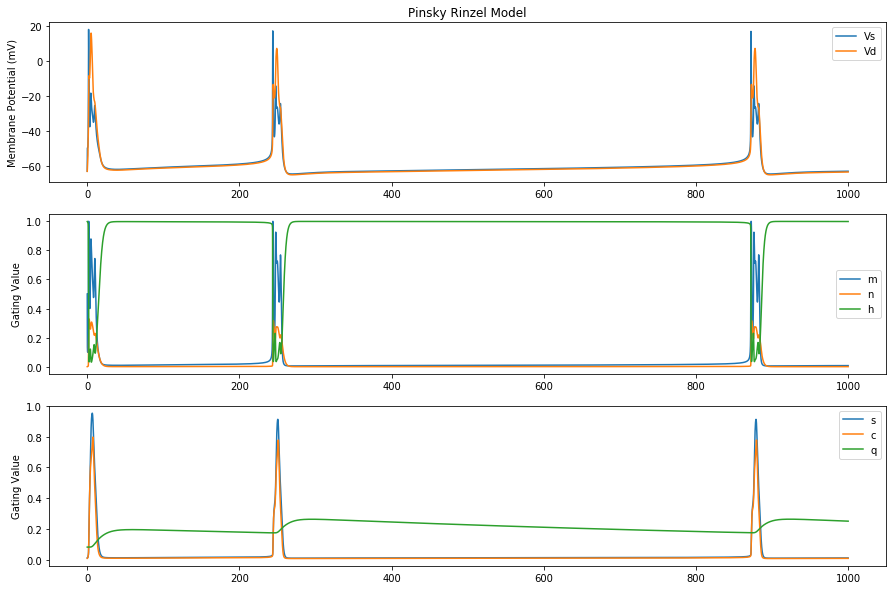

In [85]:
C0, C1, C2, C3, C4, C5, O, Vs, Vd, m, n, h, s, c, q, Ca = sol.T

Iampa = N_AMPAR * O * Isingle_max(Vd)

plt.figure(figsize=(15, 10))

plt.subplot(3,1,1)
plt.title('Pinsky Rinzel Model')
plt.plot(T, Vs, label = 'Vs')
plt.plot(T, Vd, label = 'Vd')
plt.ylabel('Membrane Potential (mV)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(T, m, label='m')
plt.plot(T, n, label='n')
plt.plot(T, h, label='h')
plt.ylabel('Gating Value')
plt.legend()

plt.subplot(3,1,3)
plt.plot(T, s, label='s')
plt.plot(T, c, label='c')
plt.plot(T, q, label='q')
plt.ylabel('Gating Value')
plt.legend()

plt.savefig('Somatic Input work.png')

plt.show()

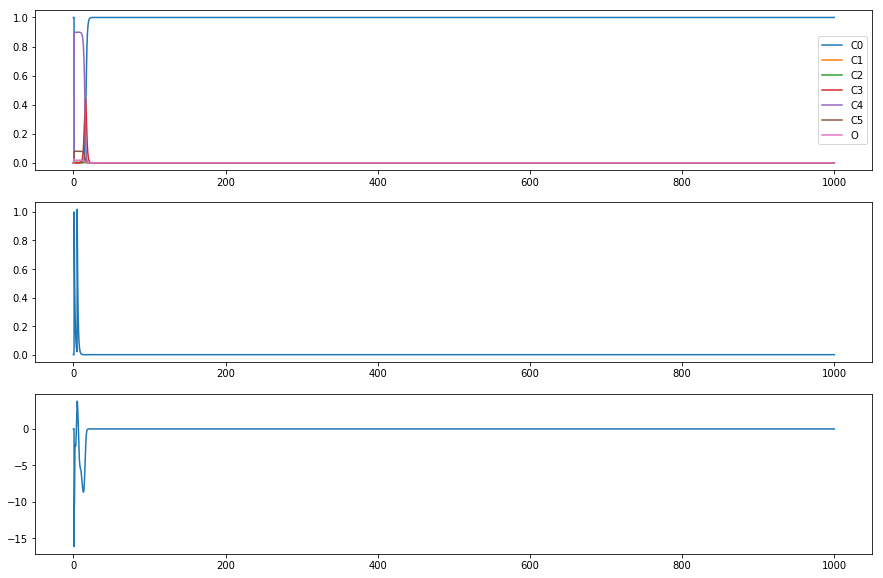

In [86]:
plt.figure(figsize=(15, 10))

plt.subplot(3,1,1)
plt.plot(T, C0, label = 'C0')
plt.plot(T, C1, label = 'C1')
plt.plot(T, C2, label = 'C2')
plt.plot(T, C3, label = 'C3')
plt.plot(T, C4, label = 'C4')
plt.plot(T, C5, label = 'C5')
plt.plot(T, O, label = 'O')
plt.legend()

plt.subplot(3,1,2)
glu = map(Glu, T)
#print glu
plt.plot(T, glu, label = 'GLu')

plt.subplot(3,1,3)
plt.plot(T, Iampa)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in exp


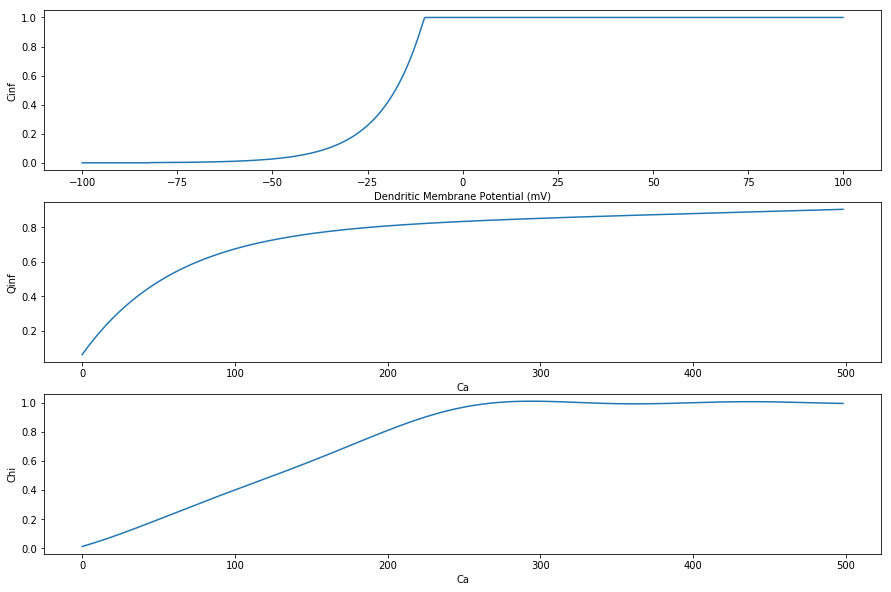

In [87]:
Vdmin, Vdmax, dVd = -100, 100, 0.1
Vd = np.arange(Vdmin,Vdmax,dVd)
Cmin, Cmax, dC = 0, 500, 2
C = np.arange(Cmin, Cmax, dC)
plt.figure(figsize = (15,10))

plt.subplot(3,1,1)
plt.plot(Vd, cinf(Vd))
plt.ylabel('Cinf')
plt.xlabel('Dendritic Membrane Potential (mV)')
plt.legend

plt.subplot(3,1,2)
plt.plot(C, qinf(C))
plt.ylabel('Qinf')
plt.xlabel('Ca')
plt.legend

plt.subplot(3,1,3)
plt.plot(C, chi(C))
plt.ylabel('Chi')
plt.xlabel('Ca')
plt.legend

#print qinf(C), cinf(Vd), chi(C)

plt.show()